In [1]:
import re
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report


In [2]:
from sklearn.model_selection import train_test_split

columns = ["ProductName", "level_1", "level_2", "level_3", "PricePerItem", "PriceMode", "HasMultiBuyDeal",
           "MultiBuyDeal", "MultiBuyBasePrice", "MultiBuyPrice", "MultiBuyQuantity", "PromoBadgeImageLabel"]
df = pd.read_csv("data.csv", usecols=columns)
df.drop_duplicates(inplace=True)
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,Johnson's Baby Lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,NaN,4.89,NaN,NaN,NaN
1,Johnson's Baby Oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,NaN,4.89,NaN,NaN,NaN
2,SMA Balanced Nutrition From Birth Infant Formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,NaN,17.99,17.99,1.0,Saver
3,Johnson's Baby Powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,NaN,2.99,2.99,1.0,Saver
4,Johnson's Baby Powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,NaN,4.89,NaN,NaN,NaN


In [3]:
punctuations = re.compile(r'[^a-zA-Z\s]+')
df["ProductName"] = [" ".join(punctuations.sub('', x).lower().split()) for x in df["ProductName"].tolist()]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,NaN,4.89,NaN,NaN,NaN
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,NaN,4.89,NaN,NaN,NaN
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,NaN,17.99,17.99,1.0,Saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,NaN,2.99,2.99,1.0,Saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,NaN,4.89,NaN,NaN,NaN


In [4]:
df["MultiBuyDeal"] = [" ".join(punctuations.sub('', y).lower().split()) if y == y else " " for y in
                      df["MultiBuyDeal"].tolist()]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,NaN,NaN,NaN
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,NaN,NaN,NaN
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,,17.99,17.99,1.0,Saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,,2.99,2.99,1.0,Saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,,4.89,NaN,NaN,NaN


In [5]:
df["PromoBadgeImageLabel"] = [" ".join(punctuations.sub('', z).lower().split()) if z == z else " " for z in
                              df["PromoBadgeImageLabel"].tolist()]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,NaN,NaN,
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,NaN,NaN,
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,,17.99,17.99,1.0,saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,,2.99,2.99,1.0,saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,,4.89,NaN,NaN,


In [6]:
df["MultiBuyPrice"].fillna(0, inplace=True)
df["MultiBuyQuantity"].fillna(0, inplace=True)
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,0.00,0.0,
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,0.00,0.0,
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,,17.99,17.99,1.0,saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,,2.99,2.99,1.0,saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,,4.89,0.00,0.0,


<BarContainer object of 449 artists>

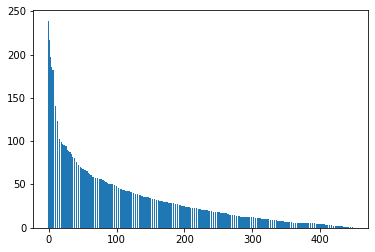

In [7]:
typesa = df.value_counts(columns[1:4])
plot.bar([a for a in range(typesa.size)], typesa)

<BarContainer object of 43 artists>

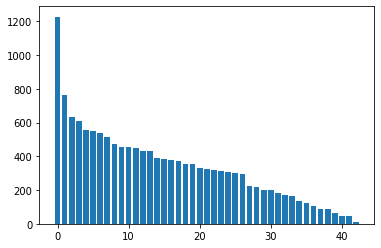

In [8]:
typesb = df.value_counts(columns[1:3])
plot.bar([a for a in range(typesb.size)], typesb)

In [9]:
typesc = df.value_counts(columns[1:2])
typesc

level_1                    
Pantry                         4740
Personal Care                  1778
Fresh Foods & Bakery           1721
Chilled, Frozen & Desserts     1426
Beer, Cider & Wine             1232
Kitchen, Dining & Household    1182
Drinks                         1063
Pets                            512
Meal Spot                       456
Baby, Toddler & Kids            354
Featured                        121
dtype: int64

In [10]:
df = df[df["level_1"] != "Featured"]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,0.00,0.0,
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,4.89,ea,False,,4.89,0.00,0.0,
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,17.99,ea,False,,17.99,17.99,1.0,saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,2.99,ea,False,,2.99,2.99,1.0,saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,4.89,ea,False,,4.89,0.00,0.0,


(array([1.974e+03, 4.555e+03, 3.223e+03, 1.367e+03, 9.790e+02, 5.380e+02,
        5.470e+02, 1.890e+02, 2.290e+02, 1.670e+02, 1.250e+02, 7.600e+01,
        2.800e+01, 2.000e+01, 2.800e+01, 1.200e+01, 2.200e+01, 6.000e+00,
        1.200e+01, 1.000e+00, 1.200e+01, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  0.15  ,   2.5668,   4.9836,   7.4004,   9.8172,  12.234 ,
         14.6508,  17.0676,  19.4844,  21.9012,  24.318 ,  26.7348,
         29.1516,  31.5684,  33.9852,  36.402 ,  38.8188,  41.2356,
         43.6524,  46.0692,  48.486 ,  50.9028,  53.3196,  55.7364,
         58.1532,  60.57  ,  62.9868,  65.4036,  67.8204,  70.2372,
         72.654 ,  75.0708,  77.4876

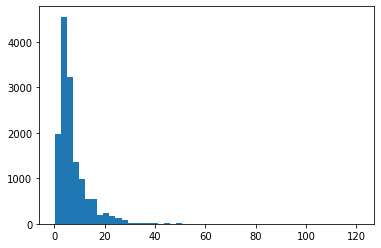

In [11]:
dfea = df[df["PriceMode"] == "ea"]
plot.hist(dfea["PricePerItem"].tolist(), bins=50)

(array([13., 21., 25., 13., 22., 30., 33.,  9., 41., 19., 45., 11.,  9.,
        14.,  9.,  1.,  3.,  3.,  7.,  2.,  2.,  1.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  2.29  ,   4.8422,   7.3944,   9.9466,  12.4988,  15.051 ,
         17.6032,  20.1554,  22.7076,  25.2598,  27.812 ,  30.3642,
         32.9164,  35.4686,  38.0208,  40.573 ,  43.1252,  45.6774,
         48.2296,  50.7818,  53.334 ,  55.8862,  58.4384,  60.9906,
         63.5428,  66.095 ,  68.6472,  71.1994,  73.7516,  76.3038,
         78.856 ,  81.4082,  83.9604,  86.5126,  89.0648,  91.617 ,
         94.1692,  96.7214,  99.2736, 101.8258, 104.378 , 106.9302,
        109.4824, 112.0346, 114.5868, 117.139 , 119.6912, 122.2434,
        124.7956, 127.3478, 129.9   ]),
 <BarContainer object of 50 artists>)

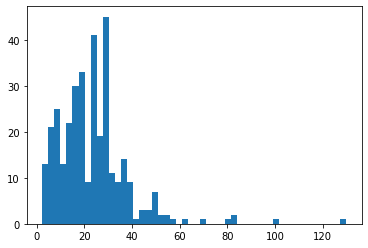

In [12]:
dfkg = df[df["PriceMode"] == "kg"]
plot.hist(dfkg["PricePerItem"].tolist(), bins=50)

In [13]:
df["PricePerItem"] = [round(p / 5) * 5 for p in df["PricePerItem"].tolist()]
df["MultiBuyPrice"] = [round(p / 5) * 5 for p in df["MultiBuyPrice"].tolist()]
df["MultiBuyBasePrice"] = [round(p / 5) * 5 for p in df["MultiBuyBasePrice"].tolist()]
df["MultiBuyQuantity"] = [int(q) for q in df["MultiBuyQuantity"].tolist()]
df.head(5)

,ProductName,level_1,level_2,level_3,PricePerItem,PriceMode,HasMultiBuyDeal,MultiBuyDeal,MultiBuyBasePrice,MultiBuyPrice,MultiBuyQuantity,PromoBadgeImageLabel
0,johnsons baby lotion,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,5,ea,False,,5,0,0,
1,johnsons baby oil,"Baby, Toddler & Kids",Baby Care,Baby Bathing & Skin Care,5,ea,False,,5,0,0,
2,sma balanced nutrition from birth infant formula,"Baby, Toddler & Kids",Baby Care,Baby Formula & Toddler Food,20,ea,False,,20,20,1,saver
3,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,5,ea,False,,5,5,1,saver
4,johnsons baby powder,"Baby, Toddler & Kids",Baby Care,Nappies & Changing,5,ea,False,,5,0,0,


<BarContainer object of 429 artists>

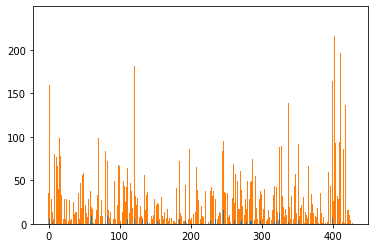

In [14]:
types = []
countt = []
countf = []
levela = df["level_1"].tolist()
levelb = df["level_2"].tolist()
levelc = df["level_3"].tolist()
state = df["HasMultiBuyDeal"].tolist()
labels = [";".join([levela[i], levelb[i], levelc[i]]) for i in range(len(levela))]
for i in range(len(labels)):
    if labels[i] in types:
        if state[i]:
            countt[types.index(labels[i])] += 1
        else:
            countf[types.index(labels[i])] += 1
    else:
        types.append(labels[i])
        countt.append(0)
        countf.append(0)
plot.bar([a for a in range(len(types))], countt)
plot.bar([a for a in range(len(types))], countf, bottom=countt)

<BarContainer object of 429 artists>

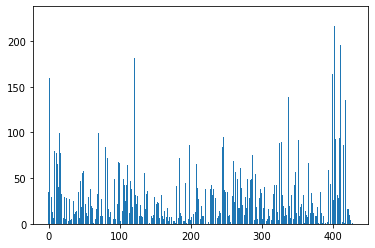

In [15]:
types = []
countt = []
countf = []
levela = df["level_1"].tolist()
levelb = df["level_2"].tolist()
levelc = df["level_3"].tolist()
state = df["PromoBadgeImageLabel"].tolist()
labels = [";".join([levela[i], levelb[i], levelc[i]]) for i in range(len(levela))]
for i in range(len(labels)):
    if labels[i] in types:
        if state[i]:
            countt[types.index(labels[i])] += 1
        else:
            countf[types.index(labels[i])] += 1
    else:
        types.append(labels[i])
        countt.append(0)
        countf.append(0)
plot.bar([a for a in range(len(types))], countt)
plot.bar([a for a in range(len(types))], countf, bottom=countt)

In [16]:
def evaluation(predictions, labels, id2label, model_name=None):
    acc = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")
    report = classification_report(labels, predictions,
                                   target_names=[id2label[i] for i in range(len(id2label))])
    info = "acc:%s, recall:%s, f1 score:%s" % (acc, recall, f1)
    if model_name is not None:
        info = "%s: %s" % (model_name, info)
    print(info)
    print(report)

In [17]:
label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {i: l for l, i in label2id.items()}
labels = [label2id[l] for l in labels]
texts = df["ProductName"].tolist()
price = df["PricePerItem"].tolist()
promotion = df["PromoBadgeImageLabel"].tolist()
multi = df["MultiBuyDeal"].tolist()
combind = [" ".join([texts[index], str(price[index]) , promotion[index], multi[index]]) for index in range(14464)]
vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(combind)
print("data len:", len(texts))
print("id2label", id2label)

data len: 14464
id2label {0: 'Pantry;Condiments & Dressings;Barbeque Sauces', 1: 'Drinks;Cold Drinks;Milk Drink Mixes', 2: 'Pantry;World Foods;USA', 3: 'Fresh Foods & Bakery;Dairy & Eggs;Yoghurt Bases', 4: 'Fresh Foods & Bakery;Bakery;Wraps & Pita Breads', 5: 'Chilled, Frozen & Desserts;Dairy & Eggs;Fresh Milk', 6: 'Pantry;Sauces, Stock & Marinades;Tomato Sauces', 7: 'Pantry;Salad & Cooking Oils;Cooking Fat', 8: 'Chilled, Frozen & Desserts;Frozen Foods;Frozen Beef, Lamb & Pork', 9: 'Fresh Foods & Bakery;Dairy & Eggs;Dairy & Lactose Free', 10: 'Fresh Foods & Bakery;Deli, Salads & Cooked Meats;Deli Meats', 11: 'Chilled, Frozen & Desserts;Dairy & Eggs;Long Life Milk & Milk Powder', 12: 'Pantry;Biscuits & Crackers;Crème & Jam Biscuits', 13: 'Meal Spot;Ready to Heat;Frozen Savouries', 14: 'Kitchen, Dining & Household;Household;Kitchenware', 15: 'Personal Care;Health & Wellness;Stop Smoking', 16: 'Beer, Cider & Wine;Beer & Cider;Brewing Supplies', 17: 'Meal Spot;Ready to Heat;Frozen Pizza & 

In [18]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=3)

In [19]:
model = LogisticRegression()
model.fit(x_train, y_train)
predict_labels = model.predict(x_test)
predict_labels = [np.round(p) for p in predict_labels]
max_label = len(id2label) - 1
predict_labels = [l if max_label >= l else max_label for l in predict_labels]
min_label = 0
predict_labels = [l if min_label <= l else min_label for l in predict_labels]
evaluation(predict_labels, y_test, id2label, "logistic")

d:\python\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: Number of classes, 401, does not match size of target_names, 429. Try specifying the labels parameter